In [86]:
import tensorflow as tf
import numpy as np

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from keras.preprocessing import image

In [87]:
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat -O vgg19.mat

--2018-08-30 17:28:21--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M) [text/plain]
Saving to: ‘vgg19.mat’

vgg19.mat           100%[=====================>] 510.12M  40.4MB/s   in 14s    

2018-08-30 17:28:35 (35.8 MB/s) - ‘vgg19.mat’ saved [534904783/534904783]



In [88]:
!wget https://images.fineartamerica.com/images-medium-large-5/12-best-art-choice-award-original-abstract-oil-painting-modern-contemporary-house-wall-deco-gallery-emma-lambert.jpg -O sty2.jpg

--2018-08-30 17:28:36--  https://images.fineartamerica.com/images-medium-large-5/12-best-art-choice-award-original-abstract-oil-painting-modern-contemporary-house-wall-deco-gallery-emma-lambert.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 54.230.19.207, 54.230.19.225, 54.230.19.95, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|54.230.19.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144994 (142K) [image/jpeg]
Saving to: ‘sty2.jpg’

sty2.jpg            100%[=====================>] 141.60K  --.-KB/s   in 0.03s  

2018-08-30 17:28:36 (4.89 MB/s) - ‘sty2.jpg’ saved [144994/144994]



In [89]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph


In [90]:
class CONFIG:
    IMAGE_WIDTH = 512
    IMAGE_HEIGHT = 512
    COLOR_CHANNELS = 3

In [91]:
path='vgg19.mat'
model=load_vgg_model(path)
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 512, 512, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 512, 512, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 512, 512, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 256, 256, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 256, 256, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 256, 256, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 128, 128, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 128, 128, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 64, 64, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 64, 64, 512) dtype=float32>, 'conv4_2': <tf.Te

In [92]:
print(os.listdir('../input'))

['con1.jpg', 'style.jpg']


In [93]:
def content_cost(c,g):
    _,nh,nw,nc=g.get_shape().as_list()
    cost=tf.reduce_sum(tf.square(c-g))/(4*nh*nw*nc)
    return cost

In [94]:
def gram_matrix(x,n):
    if n==1:
        _,nh,nw,nc=x.get_shape().as_list()
    else:
        _,nh,nw,nc=x.shape
    x=tf.transpose(tf.reshape(x,[nh*nw,nc]))
    gm=tf.matmul(x,tf.transpose(x))
    return gm

In [95]:
def layer_style_cost(s,g):
    _,nh,nw,nc=g.get_shape().as_list()
    s=gram_matrix(s,0)
    g=gram_matrix(g,1)
    cost=tf.reduce_sum(tf.square(s-g))/(4 * (nh*nw*nc)**2)
    return cost

In [96]:
style_layers=[
    ('conv1_1',0.2),
    ('conv2_1',0.2),
    ('conv3_1',0.2),
    ('conv4_1',0.2),
    ('conv5_1',0.2)
]

In [97]:
def style_cost(model,style_layers):
    j_style=0.
    for layer,coeff in style_layers:
        out=model[layer]
        s=sess.run(out)
        g=out
        layerstylecost=layer_style_cost(s,g)
        j_style+=layerstylecost*coeff
    return j_style

In [98]:
mean_vgg=np.array([103.939, 116.779, 123.68],dtype='float32').reshape([1,1,1,3])
mean_vgg

array([[[[103.939, 116.779, 123.68 ]]]], dtype=float32)

(1, 512, 512, 3)


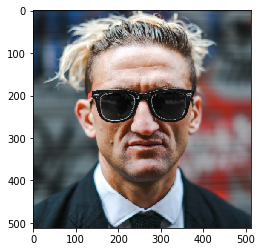

In [99]:
con=image.load_img('../input/con1.jpg',target_size=(512,512))
plt.imshow(con)
con_arr=np.asarray(con)
con_arr=np.expand_dims(con_arr,axis=0)
con_arr=con_arr-mean_vgg
print(con_arr.shape)

(1, 512, 512, 3)


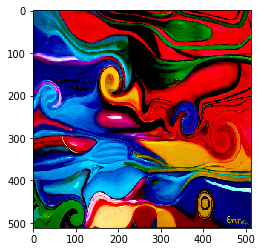

In [100]:
sty=image.load_img('./sty2.jpg',target_size=(512,512))
plt.imshow(sty)
sty_arr=np.asarray(sty)
sty_arr=np.expand_dims(sty_arr,axis=0)
sty_arr=sty_arr-mean_vgg
print(sty_arr.shape)

In [101]:
init_gen_arr=np.random.uniform(-20,20,(1,512,512,3))+con_arr

In [102]:
tf.reset_default_graph()
sess=tf.InteractiveSession()

/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1663: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [103]:
path='vgg19.mat'
model=load_vgg_model(path)
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 512, 512, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 512, 512, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 256, 256, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 256, 256, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 256, 256, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 128, 128, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 128, 128, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 64, 64, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 64, 64, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0'

In [104]:
sess.run(model['input'].assign(con_arr))
out=model['conv4_2']
c=sess.run(out)

g=out

j_content=content_cost(c,g)

In [105]:
j_style=style_cost(model,style_layers)

In [106]:
j_total=j_style*80 + j_content*10

In [107]:
optimizer=tf.train.AdamOptimizer(2.)
train_step=optimizer.minimize(j_total)
init=tf.global_variables_initializer()

In [110]:
def train(model,sess,inp_arr,iterations):
    sess.run(init)
    sess.run(model['input'].assign(inp_arr))
    for i in range(iterations):
        sess.run(train_step)
        if i%10==0:
            j=sess.run(j_total)
            js=sess.run(j_style)
            jc=sess.run(j_content)
            print(j,jc,js)
    gen_img=sess.run(model['input'])
    gen_img=gen_img+mean_vgg
    gen_img=gen_img.reshape((512,512,3))
    gen_img=np.clip(gen_img,0,255)
    gen_img=gen_img/255
    plt.imshow(gen_img)
            #plt.imshow(gen_img.reshape(512,512,3))

1829901200.0 3519.8035 22873324.0
215431380.0 4165.043 2692371.5
108514970.0 4498.1714 1355874.8
61501020.0 4502.9424 768199.9
37577230.0 4368.8955 469169.28
24816016.0 4195.3115 309675.78
17497840.0 4021.6338 218220.31
13063996.0 3866.6055 162816.62
10217909.0 3726.3354 127258.07
8297956.0 3603.5364 103274.01
6930823.5 3495.3115 86198.38
5910179.5 3400.0273 73452.234
5122802.0 3313.234 63620.867
4498531.0 3234.5007 55827.33
3993679.8 3162.731 49525.656
3577770.2 3096.0308 44335.125
3230050.5 3033.6594 39996.426
2935489.2 2975.1226 36321.727
2683081.0 2919.8936 33173.523
2464342.8 2867.8042 30445.81
2273511.0 2818.819 28066.533
2105711.2 2772.1082 25974.879
1957310.0 2727.599 24125.426
1825402.5 2685.384 22481.857
1707411.8 2645.1526 21012.004
1601159.0 2606.7515 19688.645
1505028.4 2569.89 18491.62
1417837.4 2534.2986 17406.18
1338484.0 2500.0215 16418.547
1266023.6 2467.1335 15516.903
1199647.5 2435.4744 14691.16
1138734.2 2404.903 13933.566
1082710.6 2375.3965 13236.958
1031074.06 2

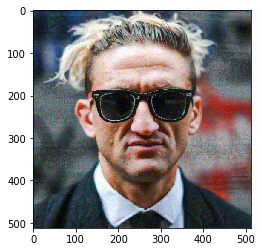

In [111]:
train(model,sess,init_gen_arr,500)